In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import gc
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from random import shuffle
from scipy.stats import spearmanr

from access_biology_data import lincs, properties
from access_science_shared import standardizer

sys.path.append('./../src/')
from aging_tools import inout, export

from access_biology_data import annotation
from access_biology_data import meta

In [4]:
outfolder = '200612_single_cell_meta'

In [5]:
save_images = True

In [6]:
p = export.get_material_path(
    '200612_probe_single_cell_differential_sum_of_raw/stats_200612_0951.xlsx')

In [7]:
df = pd.read_excel(p)

In [8]:
df

,older,organ,cell_type,rho,pval,dataset,shared
0,22,lung,B cell,-0.087221,2.122608e-13,calico,calico_22
1,22,lung,T cell,-0.109168,4.093348e-20,calico,calico_22
2,22,lung,alveolar macrophage,-0.081887,1.652837e-11,calico,calico_22
3,22,lung,ciliated columnar cell of tracheobronchial tree,-0.015438,3.132353e-01,calico,calico_22
4,22,lung,classical monocyte,-0.183017,4.098435e-53,calico,calico_22
...,...,...,...,...,...,...,...
400,18,Tongue_droplet,Langerhans cell,-0.071573,6.148387e-07,tabula_muris_10x,tabula_muris_10x_18
401,24,Tongue_droplet,basal cell of epidermis,0.155835,1.148233e-53,tabula_muris_10x,tabula_muris_10x_24
402,18,Tongue_droplet,basal cell of epidermis,-0.289361,5.495032e-178,tabula_muris_10x,tabula_muris_10x_18
403,24,Tongue_droplet,keratinocyte,0.177479,1.174045e-69,tabula_muris_10x,tabula_muris_10x_24


In [9]:
df['shared'].value_counts()

tabula_muris_facs_24    121
tabula_muris_10x_18      76
tabula_muris_10x_21      69
tabula_muris_10x_30      57
tabula_muris_10x_24      46
calico_22                28
tabula_muris_facs_18      4
tabula_muris_facs_21      4
Name: shared, dtype: int64

In [10]:
df['organ'] = df['organ'].str.replace(
    '_facs', '').str.replace('_droplet', '').str.replace('_', ' ').str.capitalize()

In [11]:
df['cell_type'] = df['cell_type'].str.capitalize()

In [12]:
df['organ'].value_counts()

Kidney               76
Lung                 54
Limb muscle          42
Spleen               41
Heart                39
Liver                27
Mammary gland        22
Thymus               19
Marrow               18
Brain non-myeloid    12
Trachea              10
Bladder              10
Pancreas              9
Tongue                8
Large intestine       7
Diaphragm             6
Skin                  3
Brain myeloid         2
Name: organ, dtype: int64

In [13]:
df = df[df['shared'].isin(
    ['tabula_muris_facs_24', 'tabula_muris_10x_24', 'calico_22']
)].copy()

In [14]:
f = (df['rho'] < 0) & (df['pval'] < 0.01)
df.loc[f, 'sign'] = -1

f = (df['rho'] > 0) & (df['pval'] < 0.01)
df.loc[f, 'sign'] = +1

f = (df['pval'] >= 0.01)
df.loc[f, 'sign'] = 0



In [15]:
df['composite'] = df['shared'] + '_' + df['organ']

In [16]:
df_export = df[['dataset', 'organ', 'cell_type', 'rho', 'pval']].rename(
    columns={'rho': 'rho_transcriptome_imbalance'}
).sort_values(['dataset', 'organ', 'cell_type'])

In [17]:
if save_images:
    export.export_full_frame(
        '{}/singel_cell_imbalances.xlsx'.format(
                outfolder),
        df_export,
        save_index=False,
        insert_date_time=False
    )

In [18]:
m = df.pivot(
    index='composite',
    columns='cell_type',
    values='sign'
)

In [19]:
mm = m.copy()

In [20]:
mm.index = [x.replace('calico_22_', 'C ') for x in mm.index]

In [21]:
mm.index = [x.replace('tabula_muris_10x_24_', 'TM ') for x in mm.index]

In [22]:
mm.index = [x.replace('tabula_muris_facs_24_', 'TF ') for x in mm.index]

In [23]:
mm = mm.sort_index()

In [24]:
is_null = mm.isnull()

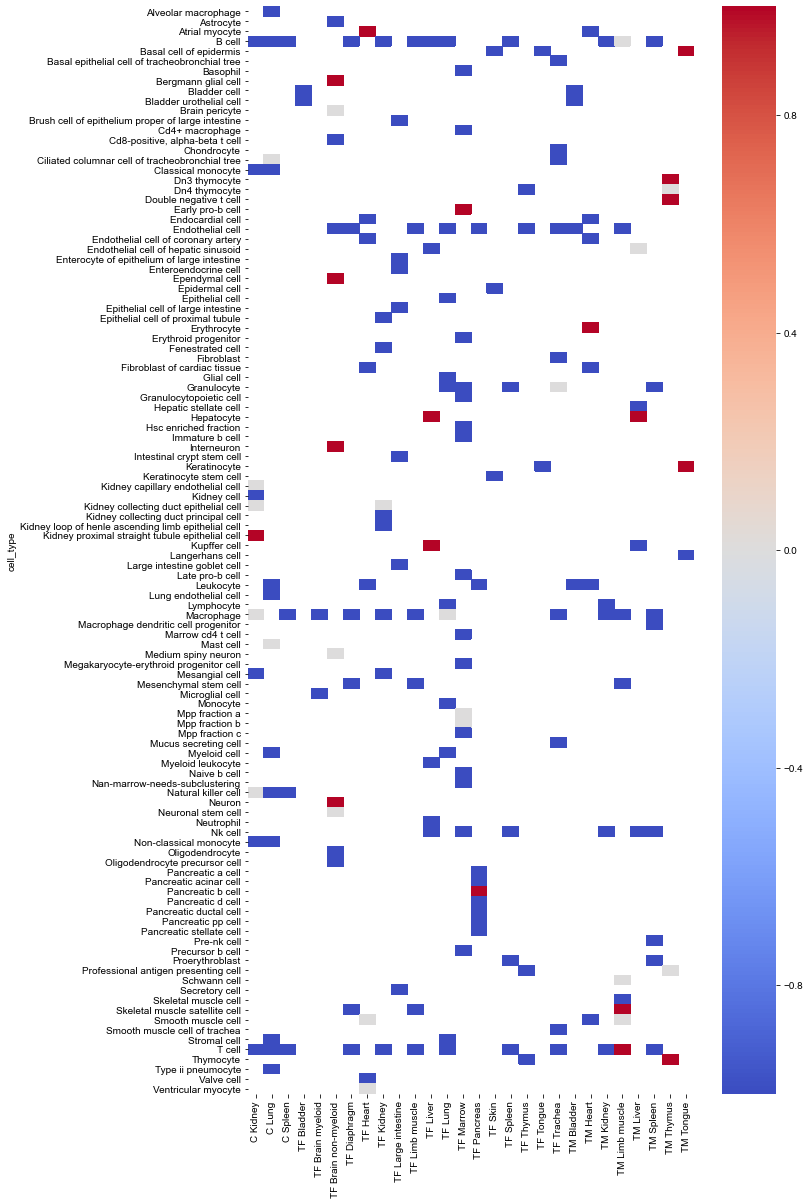

In [25]:
plt.figure(figsize=(10, 20))

sns.heatmap(
    mm.fillna(0).transpose(), 
    cmap='coolwarm',
    mask=is_null.transpose(),
    xticklabels=True,
    yticklabels=True)

if save_images:
    export.export_image(
        '{}/direction_model_organisms.pdf'.format(
            outfolder))

In [26]:
df

,older,organ,cell_type,rho,pval,dataset,shared,sign,composite
0,22,Lung,B cell,-0.087221,2.122608e-13,calico,calico_22,-1.0,calico_22_Lung
1,22,Lung,T cell,-0.109168,4.093348e-20,calico,calico_22,-1.0,calico_22_Lung
2,22,Lung,Alveolar macrophage,-0.081887,1.652837e-11,calico,calico_22,-1.0,calico_22_Lung
3,22,Lung,Ciliated columnar cell of tracheobronchial tree,-0.015438,3.132353e-01,calico,calico_22,0.0,calico_22_Lung
4,22,Lung,Classical monocyte,-0.183017,4.098435e-53,calico,calico_22,-1.0,calico_22_Lung
...,...,...,...,...,...,...,...,...,...
395,24,Thymus,Professional antigen presenting cell,0.007659,5.266041e-01,tabula_muris_10x,tabula_muris_10x_24,0.0,tabula_muris_10x_24_Thymus
398,24,Thymus,Thymocyte,0.068965,2.628429e-07,tabula_muris_10x,tabula_muris_10x_24,1.0,tabula_muris_10x_24_Thymus
399,24,Tongue,Langerhans cell,-0.032558,9.061190e-03,tabula_muris_10x,tabula_muris_10x_24,-1.0,tabula_muris_10x_24_Tongue
401,24,Tongue,Basal cell of epidermis,0.155835,1.148233e-53,tabula_muris_10x,tabula_muris_10x_24,1.0,tabula_muris_10x_24_Tongue


In [27]:
toy = df[['dataset', 'sign']].set_index('dataset')

In [28]:
toy.loc[:, 'negative'] = toy['sign']==-1
toy.loc[:, 'positive'] = toy['sign']==+1
toy.loc[:, 'neutral'] = toy['sign']==0

In [29]:
toy = toy[['negative', 'positive', 'neutral']].stack()

In [30]:
toy = toy.to_frame('present').reset_index()

In [31]:
toy

,dataset,level_1,present
0,calico,negative,True
1,calico,positive,False
2,calico,neutral,False
3,calico,negative,True
4,calico,positive,False
...,...,...,...
580,tabula_muris_10x,positive,True
581,tabula_muris_10x,neutral,False
582,tabula_muris_10x,negative,False
583,tabula_muris_10x,positive,True


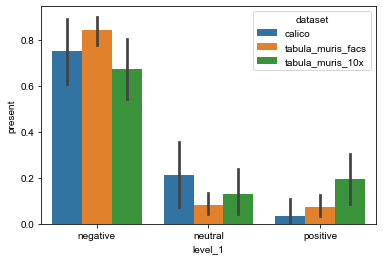

In [32]:
sns.barplot(
    hue='dataset', 
    y='present', 
    x='level_1', 
    data=toy,
    hue_order=['calico', 'tabula_muris_facs', 'tabula_muris_10x'],
    order=['negative', 'neutral', 'positive']
)



if save_images:
    export.export_image(
        '{}/fractions.pdf'.format(
            outfolder))

In [33]:
toy.groupby(['dataset', 'level_1']).sum()

present
dataset           level_1          
calico            negative     21.0
                  neutral       6.0
                  positive      1.0
tabula_muris_10x  negative     31.0
                  neutral       6.0
                  positive      9.0
tabula_muris_facs negative    102.0
                  neutral      10.0
                  positive      9.0

In [35]:
21+6+1

28

In [38]:
toy.loc[toy['present'], 'dataset'].value_counts()

tabula_muris_facs    121
tabula_muris_10x      46
calico                28
Name: dataset, dtype: int64